In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plot
import scienceplots
plot.style.use(['science', 'ieee', 'grid'])
import time

In [2]:
# Defining Functions
def MCSR(fileData, x):
    """
    Multiply MCSR formatted data with a vector x.

    Parameters:
    fileData (np.ndarray): Input matrix.
    x (np.ndarray): Input vector.

    Returns:
    np.ndarray: Resultant vector after multiplication.
    """
    n = int(fileData[0, 0])
    JM = fileData[1:, 0].astype(int) - 1
    VM = fileData[1:, 1]

    # Initialize the results array
    y = np.zeros(n)

    for i in range(n):
        y[i] = VM[i] * x[i]           # Calculating the diagonal elements
        i1 = JM[i]
        i2 = JM[i + 1] - 1
        for j in range(i1, i2 + 1):
            y[i] += VM[j] * x[JM[j]]  # Calculating the lower half with CRS format
            y[JM[j]] += VM[j] * x[i]  # Calculating the upper half with CSC format

    return y

def PowerIteration(fileData,tol):
    """
    Perform power iteration to find the dominant eigenvalue and eigenvector.
    
    Parameters:
    file_data (numpy.ndarray): Input matrix in MCSR format.
    tol (float): Tolerance for convergence criterion.
    
    Returns:
    tuple: A tuple containing the dominant eigenvalue, approximation error, and the number of iterations.
    """
    n = int(fileData[0, 0])
    q = np.ones(n) / np.sqrt(n)
    lambdas = []
    errors = []
    itnum = 0

    while True:
        z = MCSR(fileData, q)
        q = z / np.linalg.norm(z, ord=2)
        temp_lambda = np.dot(np.transpose(q), MCSR(fileData, q))
        lambdas.append(temp_lambda)
        if itnum > 0:
            error = np.abs(lambdas[-1] - lambdas[-2])
            errors.append(error)
            if error < tol:
                break
        itnum += 1
    
    return lambdas[-1], errors, itnum

def TriDiag(lowerDiagonal, mainDiagonal, upperDiagonal):
    """
    Create a tridiagonal matrix from given diagonals.

    Parameters:
    mainDiagonal (np.ndarray): Main diagonal elements.
    upperDiagonal (np.ndarray): Upper diagonal elements.
    lowerDiagonal (np.ndarray): Lower diagonal elements.

    Returns:
    np.ndarray: Tridiagonal matrix.
    """
    return np.diag(lowerDiagonal, -1) + np.diag(mainDiagonal, 0) + np.diag(upperDiagonal, 1)

def LanczosAlgorithm(fileData, m, tol):
    """
    Perform Lanczos algorithm to find eigenvalues.

    Parameters:
    file_data (np.ndarray): Input matrix in MCSR format.
    m (int): Number of Lanczos iterations.
    tol (float): Tolerance for convergence criterion.

    Returns:
    tuple: A tuple containing the dominant eigenvalue, approximation error, and the number of iterations.
    """
    n = int(fileData[0, 0])
    v = np.zeros((n, m+1))
    v[:, 1] = np.ones(n) / np.sqrt(n)
    bet = np.zeros(m+1)
    alph = np.zeros(m+1)
    
    for i in range(1, m):
        w = MCSR(fileData, v[:, i]) - bet[i - 1] * v[:, i - 1]
        alph[i] = np.dot(v[:, i], w)
        w = w - alph[i] * v[:, i]
        bet[i] = np.linalg.norm(w, ord=2)
        v[:, i+1] = w / bet[i]

    T = TriDiag(bet[1:m], alph[1:m+1], bet[1:m])
    
    q = np.ones(m) / np.sqrt(m)
    lambdas = []
    errors = []
    itnum = 0
    
    while True:
        z = np.dot(T, q)
        q = z / np.linalg.norm(z, ord=2)
        temp_lambda = np.dot(np.transpose(q), np.dot(T, q))
        lambdas.append(temp_lambda)
        if itnum > 0:
            error = np.abs(lambdas[-1] - lambdas[-2])
            errors.append(error)
            if error < tol:
                break
        itnum += 1

    return lambdas[-1], errors, itnum

In [3]:
# Importing Data
fileData = np.loadtxt("power_test_msr.txt",skiprows=1,dtype=float) 

14.467552185058594
777
7650603.313909994


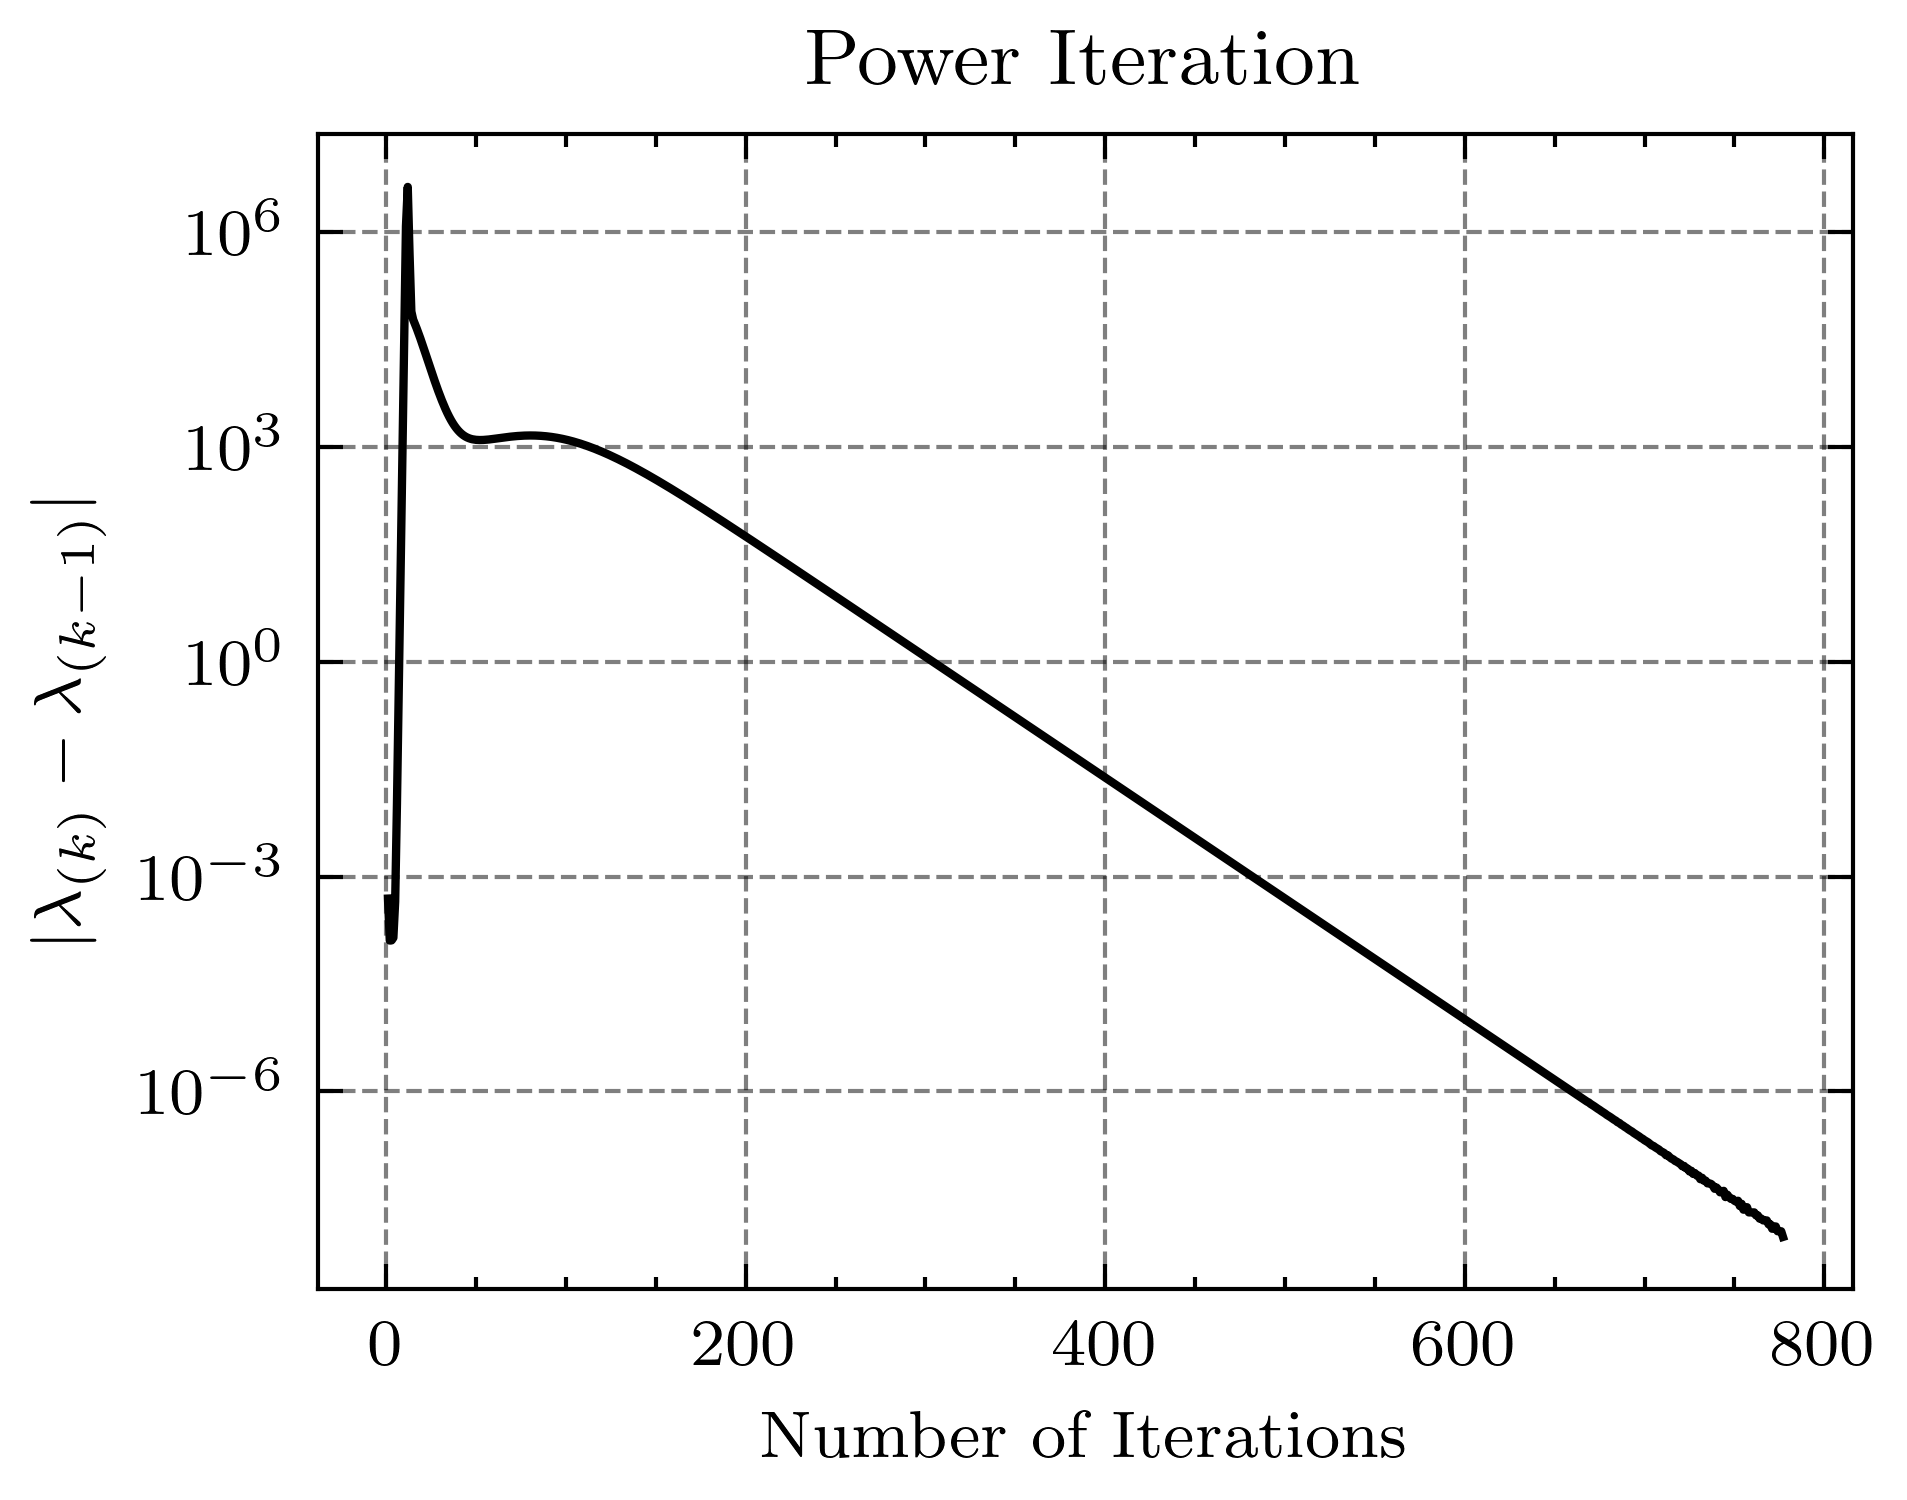

In [4]:
# Power Iteration Algorithm 
tolerance = 1e-8
start = time.time()
lambd, errors, itnum = PowerIteration(fileData,tolerance)
end = time.time()
print(end - start)
print(itnum)
print(lambd)
# Plotting the Figure
iterations = np.arange(1,itnum+1,1)
fig = plot.figure()
plot.semilogy(iterations,errors)
plot.title('Power Iteration')
plot.xlabel('Number of Iterations')
plot.ylabel(r'$|\lambda_{(k)} - \lambda_{(k-1)}|$')
plot.show()

0.2969493865966797
285
7650589.934672675


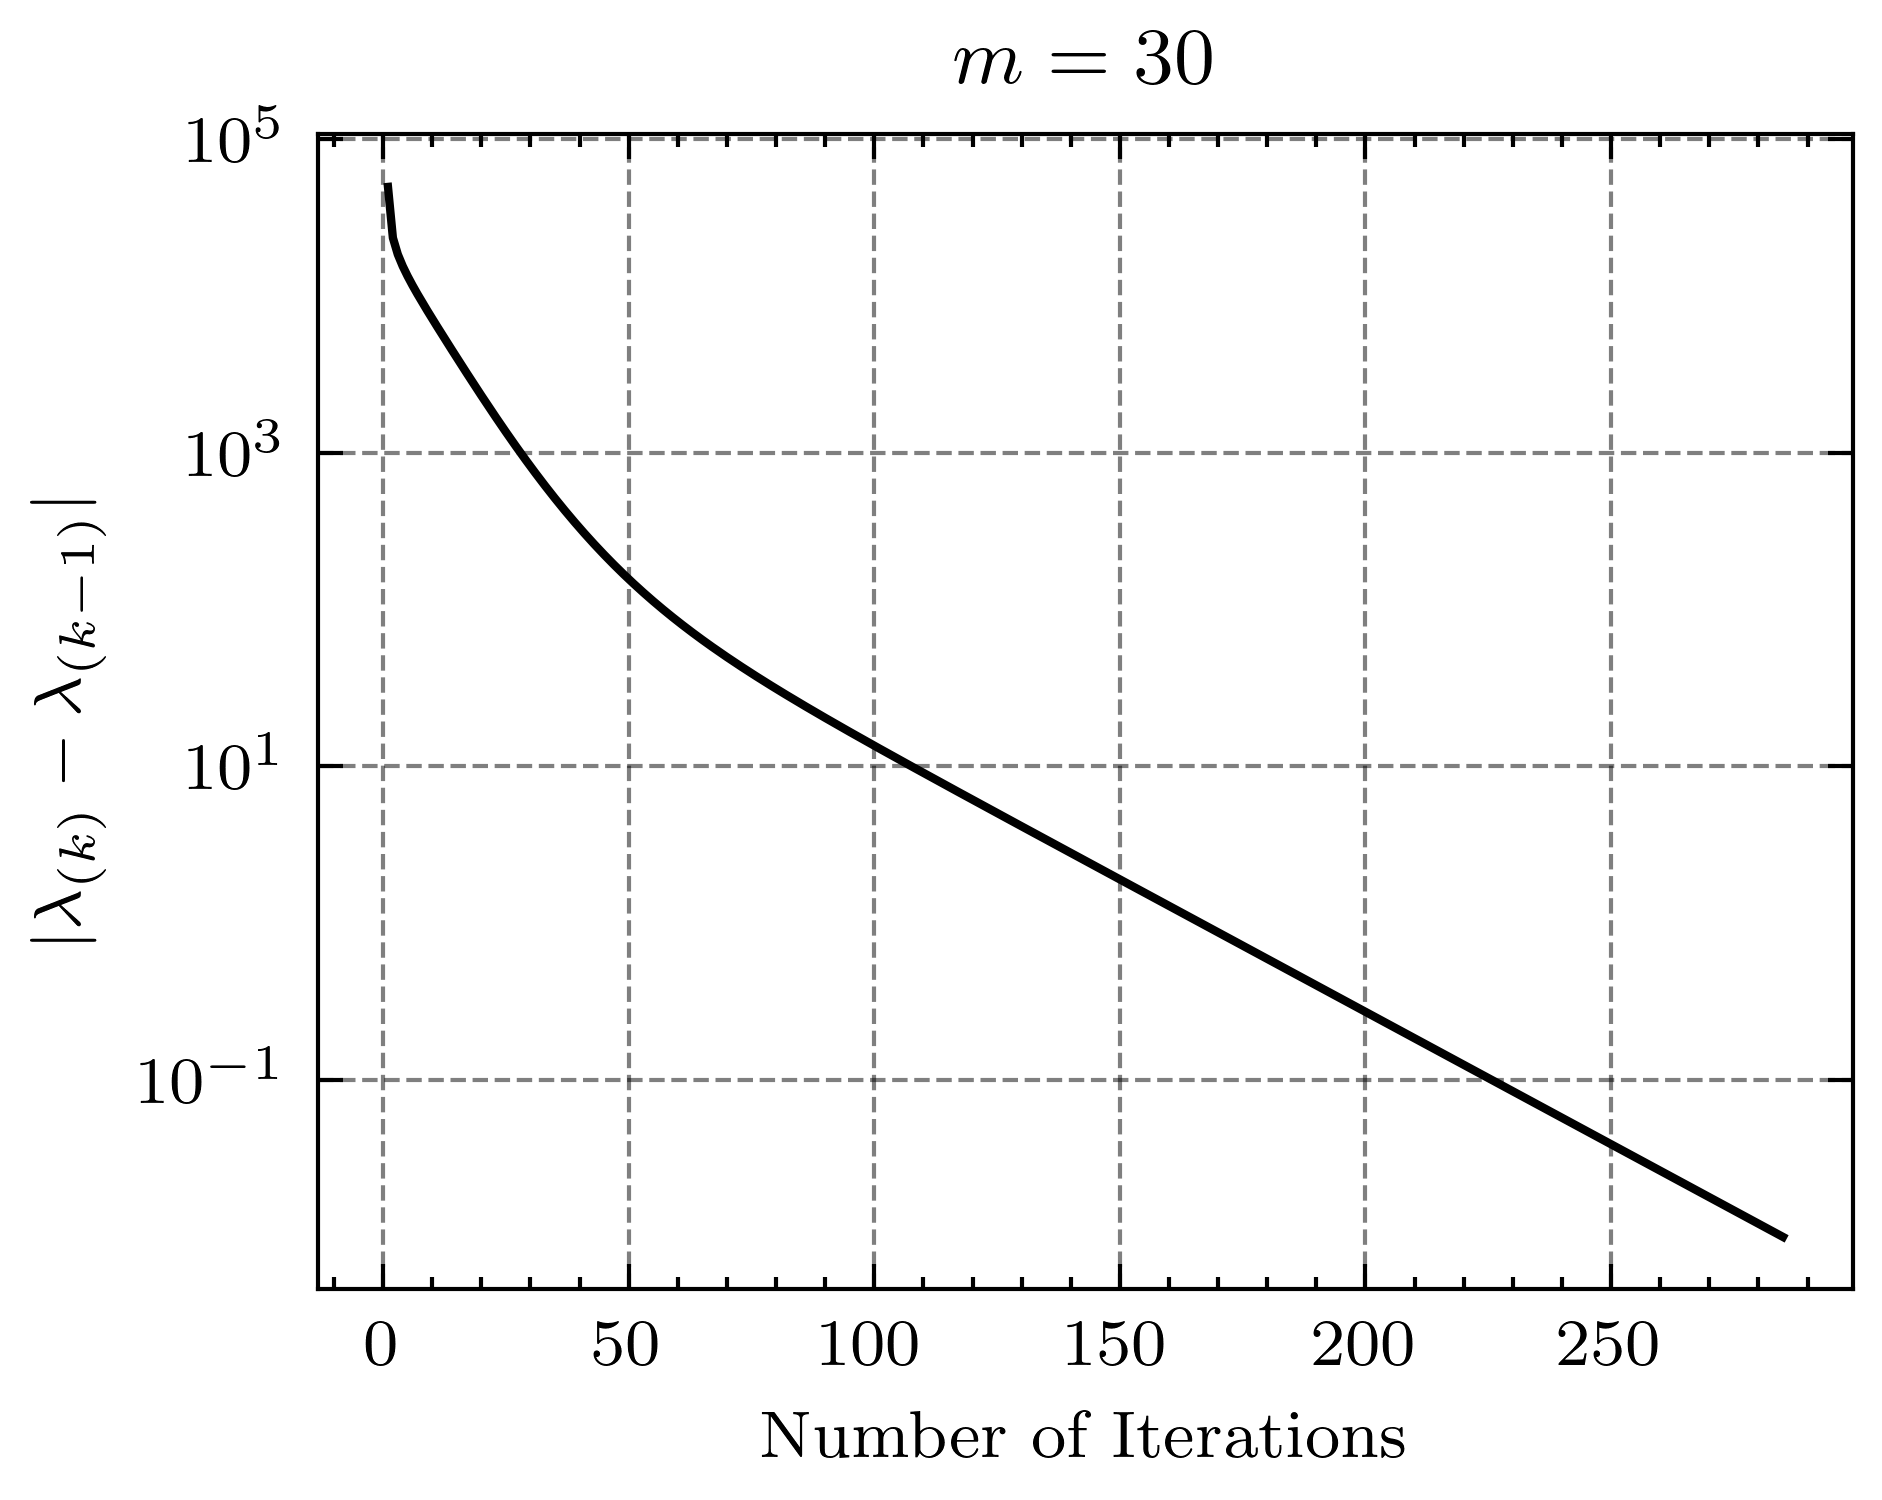

0.6261489391326904
412
7650603.311599199


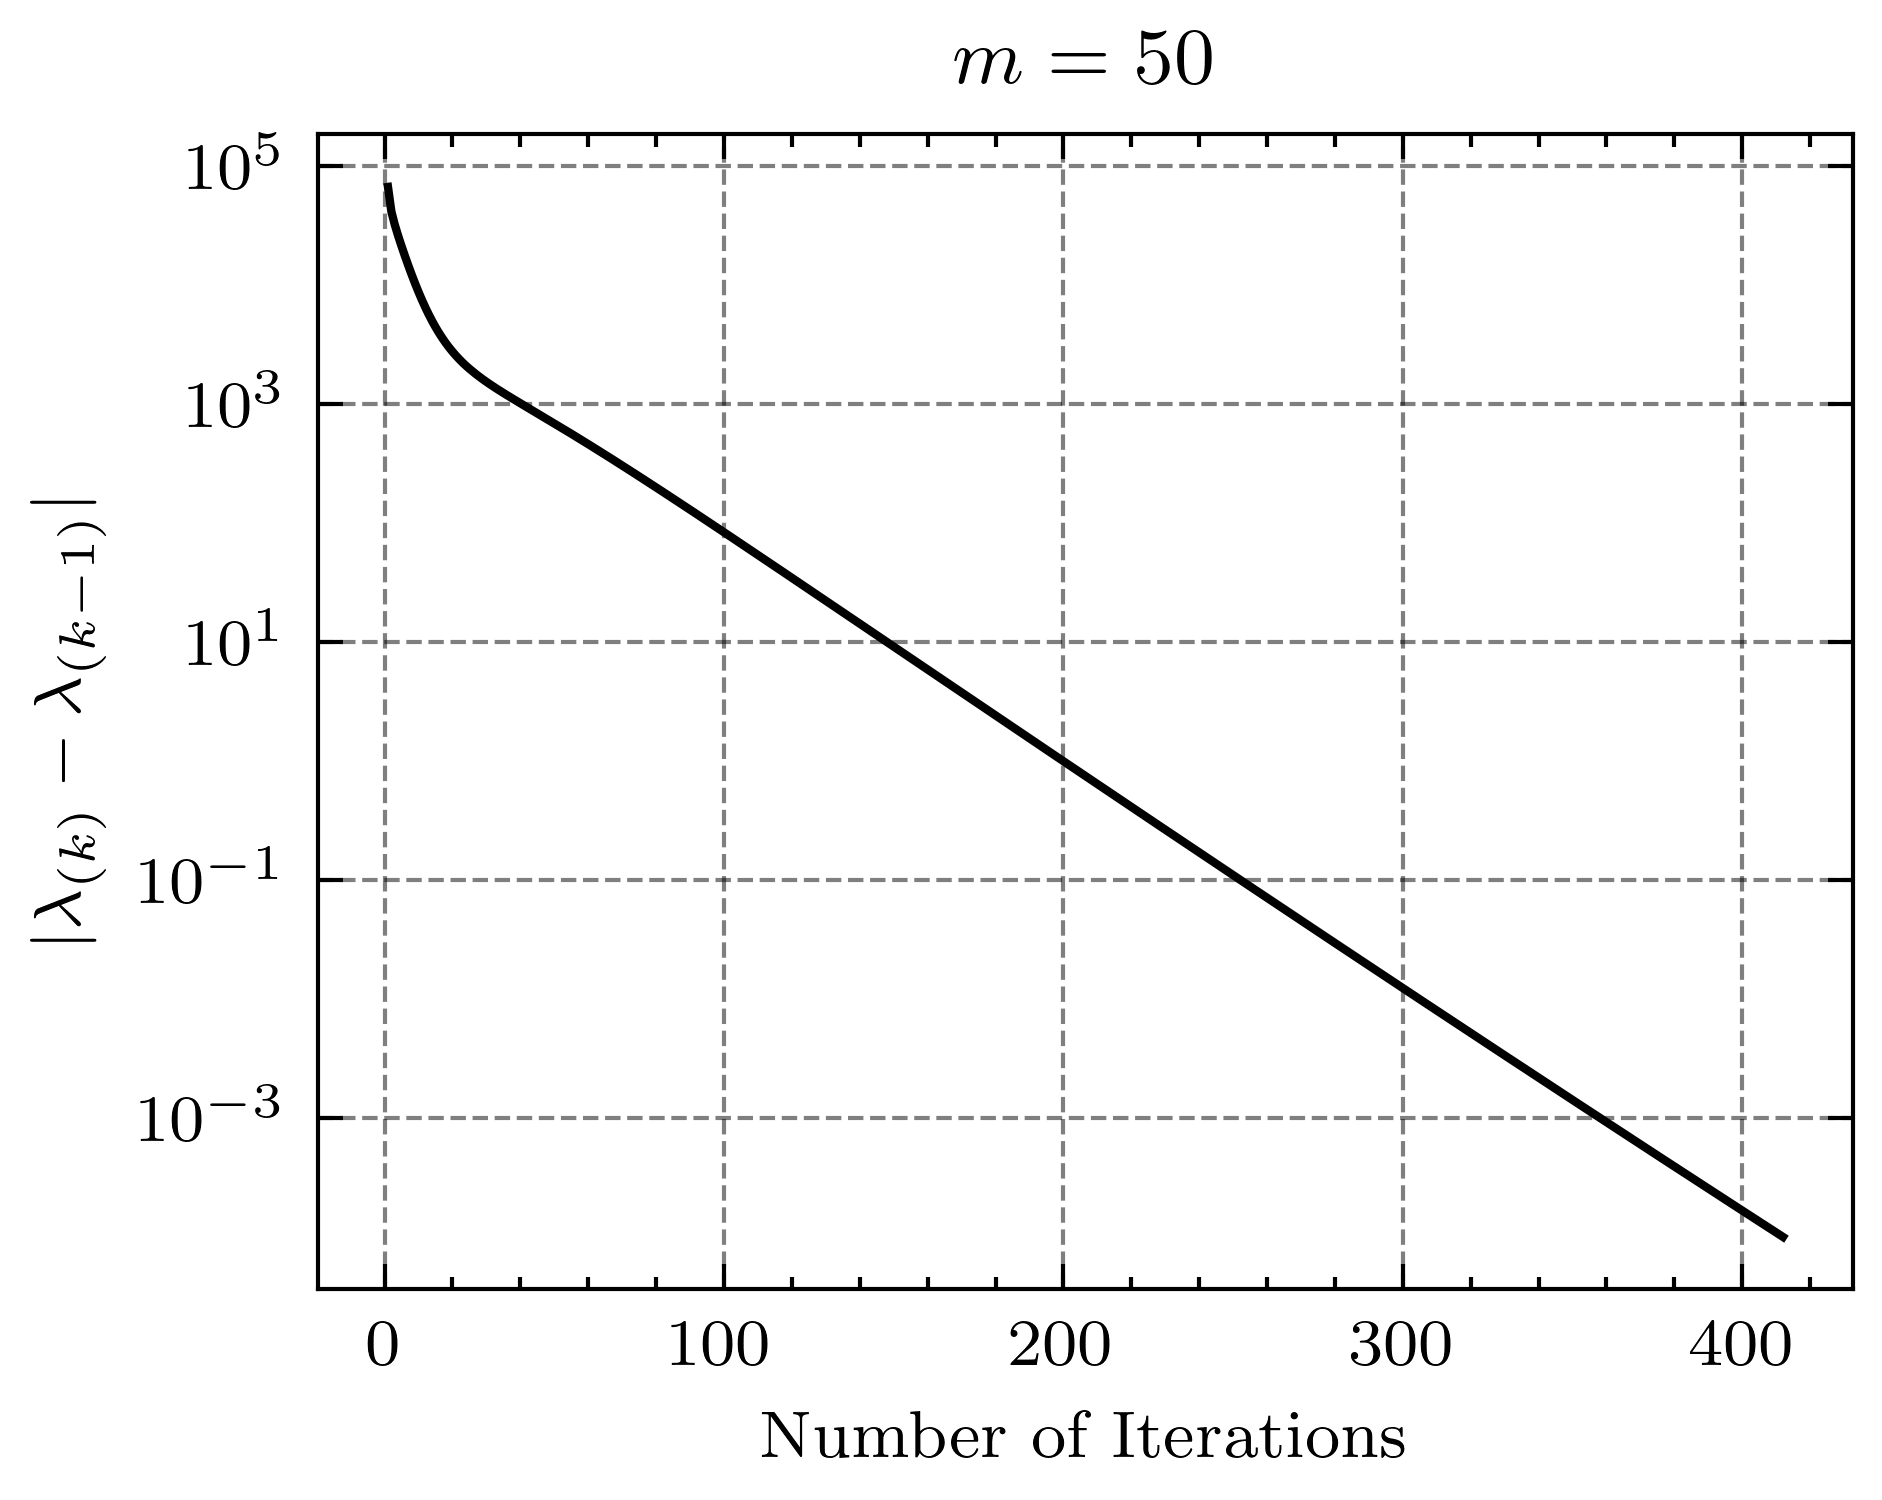

0.7300968170166016
522
7650603.313886475


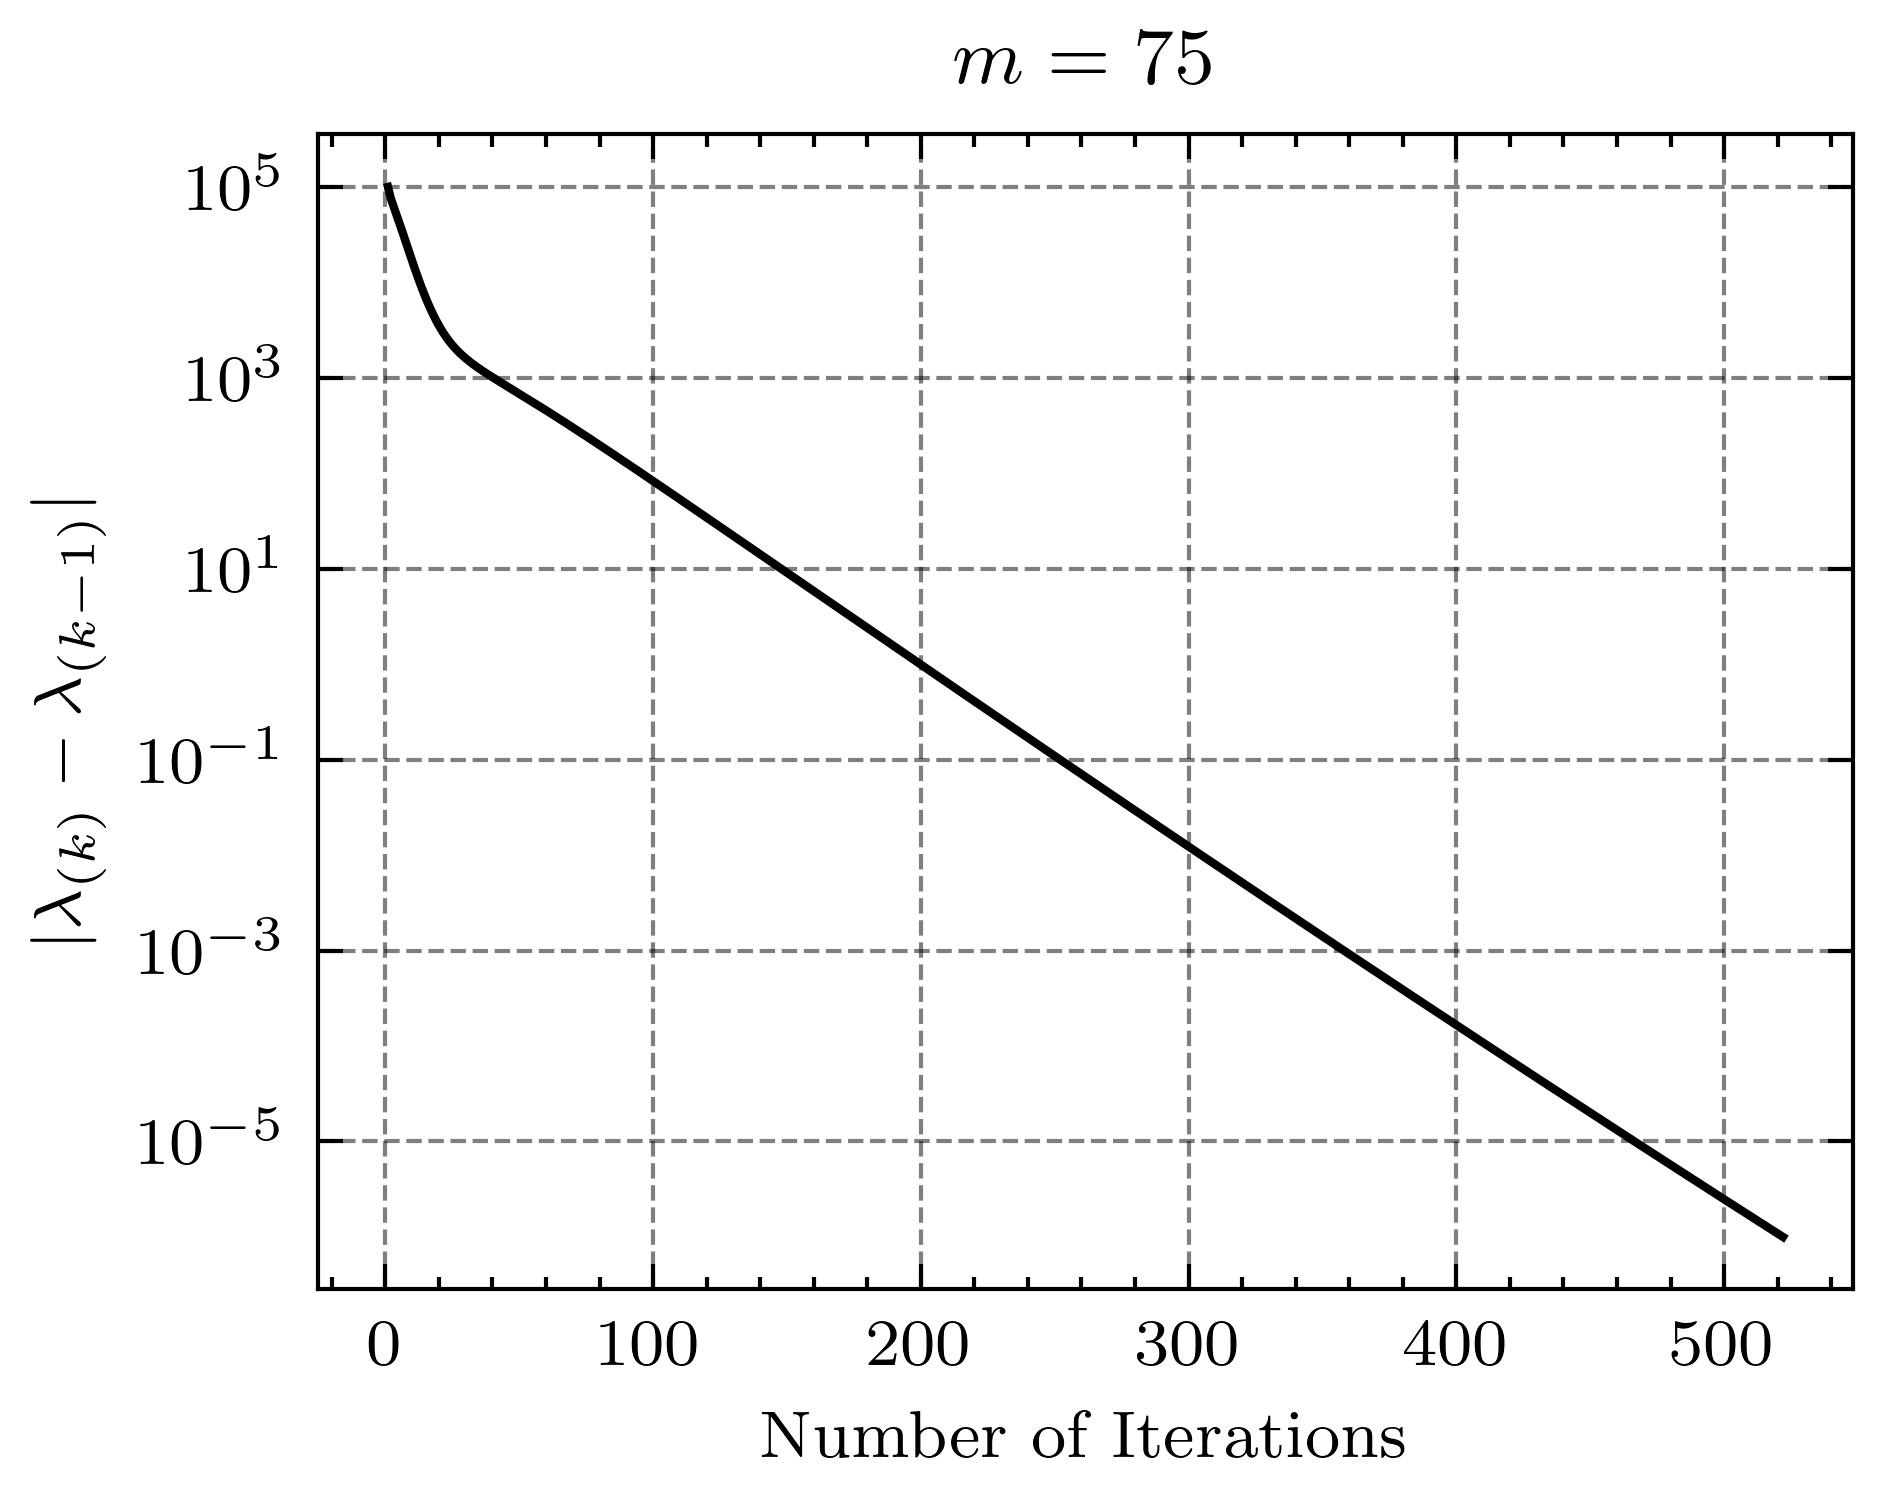

0.8654749393463135
664
7650603.313903669


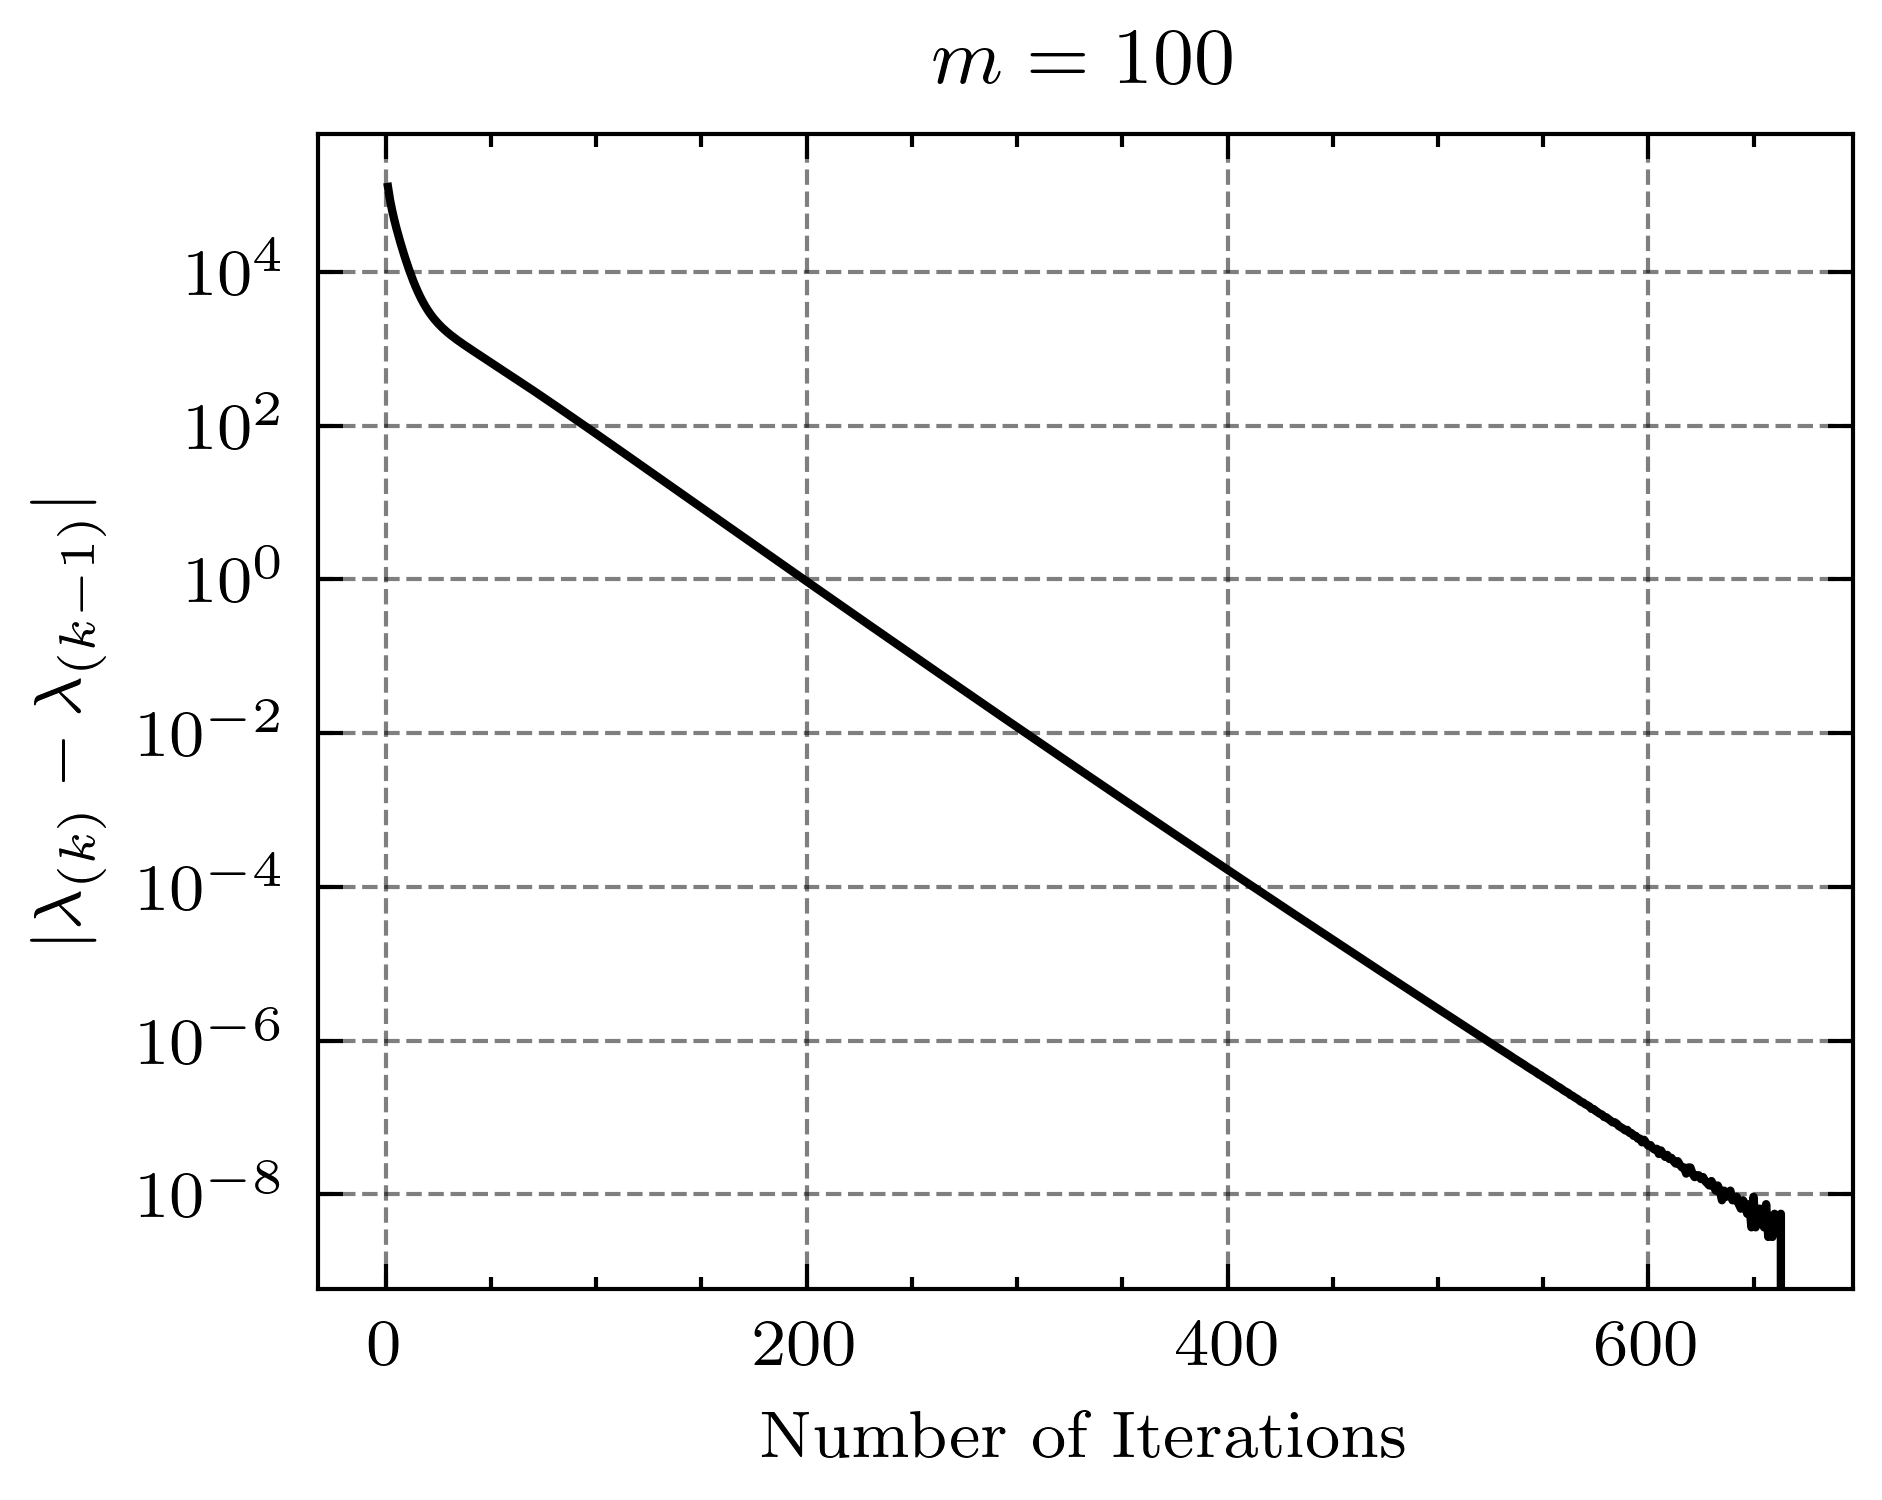

In [5]:
# Lanczos Algorithm
m = np.array([30, 50, 75, 100])
tol = np.array([1e-2, 1e-4, 1e-6, 1e-10])

for i in range(m.size):
    start = time.time()
    lambd, errors, itnum = LanczosAlgorithm(fileData,m[i],tol[i])
    end = time.time()
    print(end - start)
    print(itnum)
    print(lambd)
    # Plotting the Figure
    iterations = np.arange(1,itnum+1,1)
    plot.figure()
    plot.semilogy(iterations,errors)
    plot.title(r'$m = {}$'.format(m[i]))
    plot.xlabel('Number of Iterations')
    plot.ylabel(r'$|\lambda_{(k)} - \lambda_{(k-1)}|$')
    plot.show()